# セットアップ

## ライブラリのインポート

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import re
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [2]:
plt.style.use("ggplot")
plt.rcParams['font.family'] = "MS Gothic"
plt.rcParams["font.size"] = 20

# データの読み込み

### 訓練データの出力(購入データ)
`train_purchases.csv` \
columns: `session_id`, `item_id` \
The purchase that happened at the end of the session. One purchase per session. \
各セッションでの正解ラベル．

In [3]:
path_data = r'C:\Users\yota-\Desktop\study\mystudy\recsys\dressipi_recsys2022\data'
df_train_purchases = pd.read_csv(path_data + r"\train_purchases.csv")
display(df_train_purchases)

,session_id,item_id,date
0,3,15085,2020-12-18 21:26:47.986
1,13,18626,2020-03-13 19:36:15.507
2,18,24911,2020-08-26 19:20:32.049
3,19,12534,2020-11-02 17:16:45.92
4,24,13226,2020-02-26 18:27:44.114
...,...,...,...
999995,4439986,2915,2021-05-13 11:56:37.464
999996,4439990,8786,2020-08-22 14:28:22.382
999997,4439994,21630,2020-11-27 20:10:28.961
999998,4439999,16962,2020-11-27 11:01:41.356


購入した曜日や時間帯の情報を追加．

In [4]:
w_list = ["Mon", "Tue", "Wed", "Thr", "Fri", "Sat", "Sun"]
for idx in df_train_purchases.index:
    if idx % 10000 == 0:
        print(idx, " / ", len(df_train_purchases), end = "\r")
    datetime_list = re.findall(r"\d+", df_train_purchases.at[idx, "date"])
    datetime_list = [int(s) for s in datetime_list]
    df_train_purchases.at[idx, "date_as_datetime"] = datetime.datetime(datetime_list[0], datetime_list[1], datetime_list[2],\
                                                                   datetime_list[3], datetime_list[4])
    #df_train_purchases.at[idx, "date_as_datetime"] = datetime.datetime.strptime(df_train_purchases.at[idx, "date"], '%Y-%m-%d %H:%M:%S.')
    df_train_purchases.at[idx, "day_of_week"] = w_list[int(df_train_purchases.at[idx, "date_as_datetime"].weekday())]
    df_train_purchases.at[idx, "hour"] = datetime_list[3]
display(df_train_purchases)

,session_id,item_id,date,date_as_datetime,day_of_week,hour
0,3,15085,2020-12-18 21:26:47.986,2020-12-18 21:26:00,Fri,21.0
1,13,18626,2020-03-13 19:36:15.507,2020-03-13 19:36:00,Fri,19.0
2,18,24911,2020-08-26 19:20:32.049,2020-08-26 19:20:00,Wed,19.0
3,19,12534,2020-11-02 17:16:45.92,2020-11-02 17:16:00,Mon,17.0
4,24,13226,2020-02-26 18:27:44.114,2020-02-26 18:27:00,Wed,18.0
...,...,...,...,...,...,...
999995,4439986,2915,2021-05-13 11:56:37.464,2021-05-13 11:56:00,Thr,11.0
999996,4439990,8786,2020-08-22 14:28:22.382,2020-08-22 14:28:00,Sat,14.0
999997,4439994,21630,2020-11-27 20:10:28.961,2020-11-27 20:10:00,Fri,20.0
999998,4439999,16962,2020-11-27 11:01:41.356,2020-11-27 11:01:00,Fri,11.0


時間帯の情報も追加．

In [5]:
# for文は回したくないので，関数を定義
def hour_to_timezoon(hour):
    if hour < 6.0:
        return "midnight"
    elif hour < 10.0:
        return "morning"
    elif hour < 16.0:
        return "afternoon"
    elif hour < 21.0:
        return "night"
    else:
        return "midnight"
df_train_purchases["time_zoon"] = df_train_purchases["hour"].apply(hour_to_timezoon) # 列を追加
df_train_purchases

,session_id,item_id,date,date_as_datetime,day_of_week,hour,time_zoon
0,3,15085,2020-12-18 21:26:47.986,2020-12-18 21:26:00,Fri,21.0,midnight
1,13,18626,2020-03-13 19:36:15.507,2020-03-13 19:36:00,Fri,19.0,night
2,18,24911,2020-08-26 19:20:32.049,2020-08-26 19:20:00,Wed,19.0,night
3,19,12534,2020-11-02 17:16:45.92,2020-11-02 17:16:00,Mon,17.0,night
4,24,13226,2020-02-26 18:27:44.114,2020-02-26 18:27:00,Wed,18.0,night
...,...,...,...,...,...,...,...
999995,4439986,2915,2021-05-13 11:56:37.464,2021-05-13 11:56:00,Thr,11.0,afternoon
999996,4439990,8786,2020-08-22 14:28:22.382,2020-08-22 14:28:00,Sat,14.0,afternoon
999997,4439994,21630,2020-11-27 20:10:28.961,2020-11-27 20:10:00,Fri,20.0,night
999998,4439999,16962,2020-11-27 11:01:41.356,2020-11-27 11:01:00,Fri,11.0,afternoon


### 訓練データの入力(各セッションでのitemのビュー)
`train_sessions.csv`\
columns: `session_id`, `item_id`, `date`\
The items that were viewed in a session. The "date" column is a timestamp to miliseconds. A session is equal to a day, so a session is one user's activity on one day. The session goes up to and not including the first time the user viewed the item that they bought in the end. The last item in the session will be the last item viewed before viewing the item that they bought. To find they item they bought link to train_purchases.csv on session_id. \
各セッションにおいて，購入の直前まで見ていた商品の一覧が入力として与えられる．これをもとに，どの商品を購入したのかを当てる．

In [6]:
df_train_sessions = pd.read_csv(path_data + r"\train_sessions.csv")
display(df_train_sessions)

,session_id,item_id,date
0,3,9655,2020-12-18 21:25:00.373
1,3,9655,2020-12-18 21:19:48.093
2,13,15654,2020-03-13 19:35:27.136
3,18,18316,2020-08-26 19:18:30.833
4,18,2507,2020-08-26 19:16:31.211
...,...,...,...
4743815,4440001,20409,2020-10-30 23:37:20.658
4743816,4440001,14155,2020-10-30 23:31:56.607
4743817,4440001,14303,2020-10-30 23:36:17.934
4743818,4440001,27852,2020-10-30 23:39:55.186


# 特徴量データ
今回はここが肝になる．`feature_value_id`も利用しつつ，詳細に分析する．

In [7]:
df_item_features = pd.read_csv(path_data + r"\item_features.csv")
display(df_item_features)

,item_id,feature_category_id,feature_value_id
0,2,56,365
1,2,62,801
2,2,68,351
3,2,33,802
4,2,72,75
...,...,...,...
471746,28143,68,351
471747,28143,55,390
471748,28143,11,109
471749,28143,73,91


`feature_category_id`と`feature_value_id`をセットにした`feature_category_and_value_id`を作成する．\
これをベースに，共起行列`df_item_features_pivot`を作成する．\
`feature_category_and_value_id`は$900$次元くらいあるので，適切にPCAしないとさすがに厳しそう．

In [9]:
# カテゴリと値をセットにした列を追加
df_item_features["feature_category_and_value"] = df_item_features["feature_category_id"].astype("str") + "-" + df_item_features["feature_value_id"].astype("str")
display(df_item_features)

# pivotで共起行列を生成
df_item_features_pivot = df_item_features.pivot_table(values = "feature_value_id", index = "item_id", columns = "feature_category_and_value", aggfunc = "count")
df_item_features_pivot.fillna(0.0, inplace = True) # 標準化のためnaを0で埋める
display(df_item_features_pivot)

,item_id,feature_category_id,feature_value_id,feature_category_and_value
0,2,56,365,56-365
1,2,62,801,62-801
2,2,68,351,68-351
3,2,33,802,33-802
4,2,72,75,72-75
...,...,...,...,...
471746,28143,68,351,68-351
471747,28143,55,390,55-390
471748,28143,11,109,11-109
471749,28143,73,91,73-91


feature_category_and_value,1-143,1-358,1-461,1-517,1-60,1-771,10-147,10-159,10-184,10-217,...,73-544,73-91,8-157,8-323,8-420,8-636,9-175,9-178,9-190,9-369
item_id,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28141,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 主成分分析

In [10]:
df_item_features_pca = df_item_features_pivot.apply(lambda x:  (x - x.mean()) / x.std(), axis = 0) # PCAのため，各列のデータを標準化(自動で標準化してほしい)
print("==============すべてのitemに対し，0が入っているのはこの特徴量たち==============")
display(df_item_features_pca.loc[:,df_item_features_pca.isnull().any()]) # すべてのitemに対し0であるような列の場所を確認
df_item_features_pca.fillna(0.0, inplace = True) # すべてのitemに対し0であるような列は標準化がうまくいかずNaNが生じるため，このタイミングで再度fillnaする必要あり

# 主成分分析
pca = PCA()
pca.fit(df_item_features_pca)
feature = pca.transform(df_item_features_pca)
print("==============すべての商品に対しPCAした結果は以下==============")
df_item_features_pca = pd.DataFrame(feature, columns = ["PC{}".format(x + 1) for x in range(len(df_item_features_pca.columns))], index = df_item_features_pivot.index)
display(df_item_features_pca)

==============すべてのitemに対し，0が入っているのはこの特徴量たち==============


feature_category_and_value
item_id
2
3
4
7
8
...
28139
28140
28141


==============すべての商品に対しPCAした結果は以下==============


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC895,PC896,PC897,PC898,PC899,PC900,PC901,PC902,PC903,PC904
item_id,,,,,,,,,,,,,,,,,,,,,
2,1.566401,6.418067,0.572790,0.141237,2.201028,-3.164998,1.266175,-0.129618,-1.340141,0.844216,...,-2.588207e-15,-1.272726e-15,-1.970646e-15,-1.752071e-15,1.151856e-15,1.394718e-15,1.110223e-15,4.623038e-16,-8.118506e-16,-1.571659e-15
3,-2.937146,-2.584620,-0.272016,-1.718904,-0.223110,0.296577,0.470426,-0.845872,-1.477049,0.336814,...,-9.367507e-16,-3.012811e-16,-5.551115e-17,-4.284767e-16,-3.608225e-16,4.017620e-15,1.526557e-16,-1.196092e-15,-5.342948e-16,-1.165734e-15
4,-3.026175,-2.302284,2.013440,-4.572022,1.033448,0.417674,-0.629848,0.377923,-0.518031,0.248276,...,-3.330669e-15,-7.835343e-16,-1.304512e-15,-7.546047e-16,9.436896e-16,1.408595e-15,1.151856e-15,4.831205e-16,-8.396062e-16,-1.037365e-15
7,-0.585391,-0.077455,-1.542505,3.695476,1.294438,0.069797,0.551372,0.480226,-2.269745,2.268618,...,1.422473e-15,-3.635420e-15,-1.693090e-15,4.192827e-15,7.494005e-16,2.775558e-15,-2.053913e-15,-5.715914e-16,-8.396062e-16,-1.434616e-15
8,-2.864792,-1.921805,0.130042,-3.348872,-1.056777,-1.552866,0.479299,-0.550822,0.351656,-0.394965,...,-4.857226e-16,7.464918e-16,-1.665335e-15,-2.062586e-15,3.747003e-16,1.033895e-15,-1.110223e-15,-1.899522e-16,6.245005e-17,-4.024558e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28139,-2.445808,-1.297026,-2.118066,-1.373676,-1.212859,-0.379804,-0.106126,0.416710,-1.554064,1.659965,...,-2.428613e-16,-9.847605e-18,1.637579e-15,5.360296e-15,-2.081668e-15,-2.470246e-15,3.191891e-16,3.494600e-15,1.276756e-15,1.214306e-17
28140,9.744423,-2.893583,0.494055,-1.112732,-0.771403,-0.521819,-3.495274,-4.613761,-1.522482,-0.991618,...,4.996004e-16,3.053113e-16,2.053913e-15,2.775558e-16,7.771561e-16,1.110223e-15,-7.216450e-16,1.332268e-15,-4.440892e-16,-1.554312e-15
28141,-2.424379,-2.375264,2.991170,-1.665241,3.789238,0.083158,-3.555375,2.109674,1.089622,-0.038276,...,7.840950e-16,1.658956e-15,0.000000e+00,8.777701e-16,2.220446e-15,2.088607e-15,-1.901257e-15,-4.813858e-16,1.089406e-15,-1.035630e-15


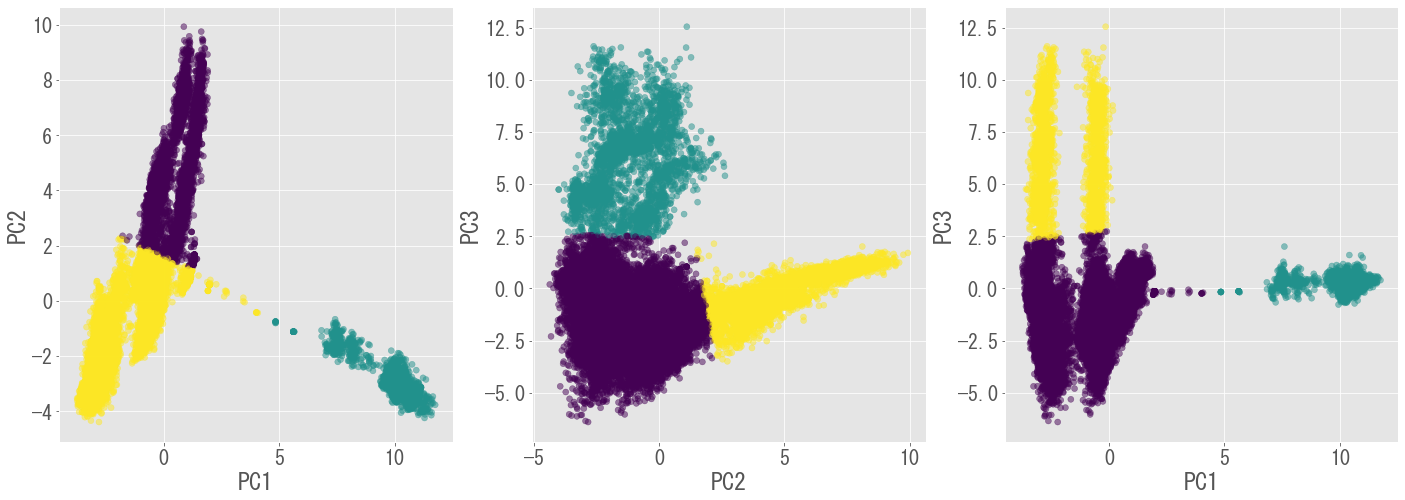

In [22]:
pca_pair_list = [["PC1", "PC2"], ["PC2", "PC3"], ["PC1", "PC3"]]

fig = plt.figure(figsize = (24, 8))

for idx, pair in enumerate(pca_pair_list):
    pred = KMeans(n_clusters = 3).fit_predict(df_item_features_pca[pair].values) # 2次元に落とした結果をクラスタリング．
    ax = fig.add_subplot(1, len(pca_pair_list), idx + 1)
    pca_x, pca_y = pair # x軸とy軸
    ax.scatter(df_item_features_pca[pca_x], df_item_features_pca[pca_y], alpha = 0.5, c = pred)
    ax.set_xlabel(pca_x)
    ax.set_ylabel(pca_y)

Text(0, 0.5, '各固有ベクトルの固有値')

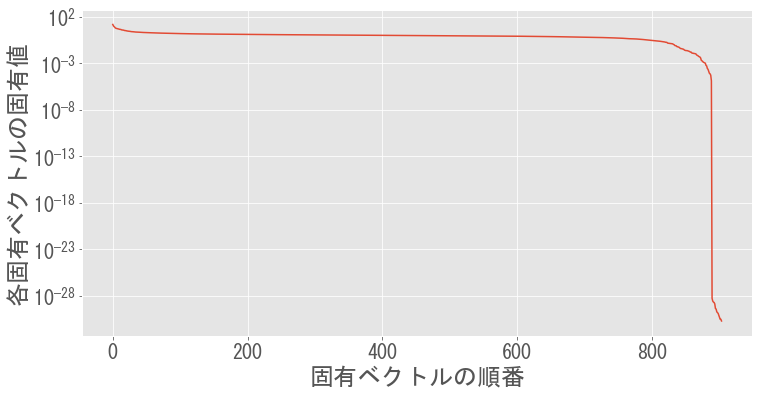

In [12]:
ax = plt.figure(figsize = (12, 6)).add_subplot(1, 1, 1)
ax.plot(np.arange(len(pca.explained_variance_)), pca.explained_variance_)
ax.set_yscale("log")
ax.set_xlabel('固有ベクトルの順番')
ax.set_ylabel("各固有ベクトルの固有値")

In [13]:
df_pca_components = pd.DataFrame(pca.components_, index = ["PC{}".format(x + 1) for x in range(len(df_item_features_pca.columns))], columns = df_item_features_pivot.columns)
display(df_pca_components)

feature_category_and_value,1-143,1-358,1-461,1-517,1-60,1-771,10-147,10-159,10-184,10-217,...,73-544,73-91,8-157,8-323,8-420,8-636,9-175,9-178,9-190,9-369
PC1,-0.003827,-2.029741e-04,-2.826316e-02,-3.589294e-04,-1.676999e-04,-4.363354e-04,-0.006594,-0.008861,-0.001031,-0.003161,...,-5.493893e-02,-3.091303e-02,-0.011146,-0.023808,-0.010816,-0.027210,-0.005144,-0.000079,-0.007603,-0.007114
PC2,-0.005252,-2.436081e-04,-3.819068e-02,-1.220524e-03,-4.361404e-04,-3.604958e-04,-0.004729,-0.002105,-0.001147,-0.003917,...,-2.664838e-02,-4.163512e-02,-0.009919,-0.017409,-0.008042,-0.014653,-0.006660,-0.000317,-0.008603,-0.007407
PC3,0.009232,9.881299e-04,9.744859e-02,2.865081e-03,2.301427e-03,4.131757e-03,0.027641,0.065815,0.007131,0.017926,...,2.127973e-02,-4.314911e-02,0.073172,0.167279,0.074979,0.177324,0.023656,0.002161,0.022968,0.017647
PC4,-0.003201,2.834993e-03,-3.998963e-02,1.803800e-03,9.993548e-04,2.198094e-03,-0.000322,0.033021,0.003124,0.029612,...,-1.781767e-01,6.161008e-02,0.050100,0.090871,0.034618,0.072347,-0.004540,0.002239,-0.016532,-0.020222
PC5,0.019976,1.144846e-02,2.212646e-01,1.251055e-02,8.678565e-03,1.169152e-02,-0.018050,-0.024808,-0.003614,-0.001879,...,-1.934686e-01,4.233582e-02,-0.040560,-0.101428,-0.040682,-0.082656,0.045944,0.008246,0.032744,0.012017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PC900,-0.000000,9.090754e-17,5.460952e-16,-1.522211e-16,-4.613129e-17,-3.689176e-17,-0.001020,-0.002386,-0.000283,-0.001149,...,3.033056e-17,4.282599e-17,-0.005985,-0.011584,-0.004966,-0.012350,0.008972,0.001270,0.009494,0.006953
PC901,-0.000000,-9.793227e-17,-1.005466e-16,6.890122e-17,-9.434083e-17,1.422053e-16,0.000156,0.000364,0.000043,0.000175,...,-8.085438e-17,-7.624652e-17,0.117348,0.227139,0.097383,0.242169,-0.010442,-0.001478,-0.011050,-0.008092
PC902,0.000000,-2.685405e-17,3.978606e-16,1.336227e-16,-2.556741e-18,1.153614e-16,-0.000568,-0.001329,-0.000158,-0.000640,...,-7.237050e-17,6.364267e-17,0.030055,0.058174,0.024941,0.062023,-0.001939,-0.000275,-0.002052,-0.001503
PC903,0.000000,4.853773e-17,8.849232e-16,-1.203063e-16,-3.248093e-17,-1.465775e-16,-0.001261,-0.002950,-0.000350,-0.001421,...,-1.214306e-17,-1.019150e-17,-0.063894,-0.123674,-0.053024,-0.131858,-0.004023,-0.000570,-0.004257,-0.003118


Text(0, 0.5, 'PC2')

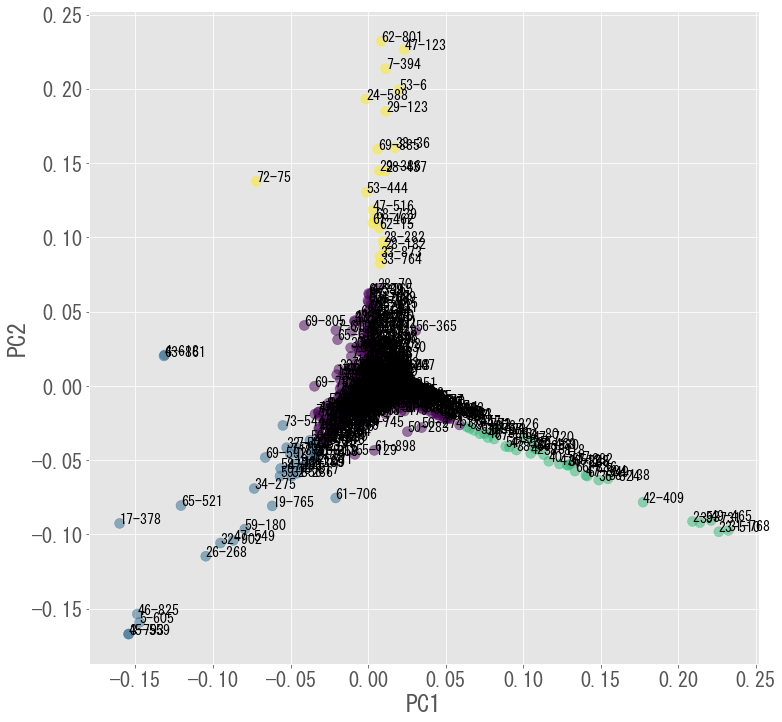

In [14]:
pred = KMeans(n_clusters = 4).fit_predict(pca.components_[[0,1]].T) # 2次元に落とした結果をクラスタリング．

ax = plt.figure(figsize = (12, 12)).add_subplot(1, 1, 1)

# 第一主成分と第二主成分における観測変数の寄与度をプロットする
for x, y, name in zip(pca.components_[0], pca.components_[1], df_item_features_pivot.columns.values):
    ax.text(x, y, name, fontsize = 14)
ax.scatter(pca.components_[0], pca.components_[1], alpha=0.5, c = pred, s = 100.0)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")

In [16]:
num_prediction_list = 100 # 100位までを出力
df_test_leaderboard = pd.read_csv(path_data + r"\test_leaderboard_sessions.csv")
display(df_test_leaderboard)

,session_id,item_id,date
0,26,19185,2021-06-16 09:53:54.158
1,200,17089,2021-06-25 12:23:40.811
2,200,17089,2021-06-25 12:24:36.631
3,200,8060,2021-06-25 12:24:41.677
4,200,4758,2021-06-25 12:24:50.692
...,...,...,...
229349,4439653,25955,2021-06-11 10:22:57.47
229350,4439653,12179,2021-06-11 10:23:00.663
229351,4439757,2078,2021-06-30 11:42:15.073
229352,4439757,2078,2021-06-30 11:43:13.725


In [18]:
# 主成分空間上での距離を定義し，近いものをリストアップする関数
def search_nearest_neighborhood_by_pca(item_id_list, num_prediction_list = 100):
    mean_vec = df_item_features_pca.loc[item_id_list].mean(axis = 0).values # ビューに含まれる各itemについて，主成分空間の座標の重心を計算
    # lambda式よりもこちらの方が圧倒的に速い．
    df_item_features_pca_minus_mean = df_item_features_pca - mean_vec # 主成分空間において，どれだけ離れているかを計算
    df_item_features_pca_distance = df_item_features_pca_minus_mean * df_item_features_pca_minus_mean # 各成分を二乗
    # 主成分について和をとることで，二乗距離を計算．ついでにソート．
    df_item_features_pca_distance = df_item_features_pca_distance.sum(axis = 1).to_frame().sort_values(by = 0, ascending = True)
    df_item_features_pca_distance.drop(index = item_id_list, inplace = True) # viewに入っているものは答えにならないはずなので，dropしておく
    return df_item_features_pca_distance[0: num_prediction_list].index.values


# 主成分空間上の距離に基づいてpredictionする
def predict_by_pca(df_test):
    df_pred = pd.DataFrame(columns = ["session_id", "item_id", "rank"])
    session_id_list = df_test["session_id"].unique()
    #df_pred["session_id"] = pd.Series(session_id_list).repeat(num_prediction_list) # 縦につなげていくと時間がかかりそうなので，初めに空の容器を作る
    
    df_pred = pd.DataFrame(columns = ["session_id", "item_id", "rank"], index = range(len(session_id_list)*num_prediction_list))
    df_pred["session_id"] = np.repeat(session_id_list, num_prediction_list, axis = 0)
    df_pred["rank"] = np.tile(range(1, num_prediction_list+1), len(session_id_list))
    item_id_values = np.zeros(len(df_pred))
    
    # print(session_id_list)
    for idx, session_id in enumerate(session_id_list):
        if idx % 100 == 0:
            print(idx, "/", len(session_id_list), end = "\r")
        item_id_list = df_test[df_test["session_id"] == session_id]["item_id"].values
        pred_list = search_nearest_neighborhood_by_pca(item_id_list)
        
        item_id_values[idx*num_prediction_list: (idx+1)*num_prediction_list] = np.array(pred_list)
        # df_pred.loc[idx*num_prediction_list:(idx+1)*num_prediction_list, "item_id"] = pred_list
        # df_pred.loc[idx*num_prediction_list:(idx+1)*num_prediction_list-1, "rank"] = range(num_prediction_list)
        
        # df_pred.loc[df_pred["session_id"] == session_id, "item_id"] = pred_list
        # df_pred.loc[df_pred["session_id"] == session_id, "rank"] = range(1, num_prediction_list+1, 1)
        
    df_pred["item_id"] = item_id_values
    df_pred["item_id"] = df_pred["item_id"].astype("int")
    return df_pred


df_submit = predict_by_pca(df_test_leaderboard)
# df_submit["rank"] = df_submit["rank"] + 1

path_submit = r'C:\Users\yota-\Desktop\study\mystudy\recsys\dressipi_recsys2022\submits'
df_submit.to_csv(path_submit + r"\nearest_neighborhood_by_pca.csv", index = False)

In [19]:
df_submit

,session_id,item_id,rank
0,26,16411,1
1,26,6350,2
2,26,3260,3
3,26,20410,4
4,26,17740,5
...,...,...,...
4999995,4439757,15893,96
4999996,4439757,24067,97
4999997,4439757,27535,98
4999998,4439757,12004,99


スコアは0.048078353783123966，
順位は1146位